In [1]:
import torch
torch.cuda.empty_cache()



[INFO] Running Grad-CAM for BreastNetPP
[DEBUG] Available memory: 862.52 MB
Loaded pretrained weights for efficientnet-b0
[INFO] Processing BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png


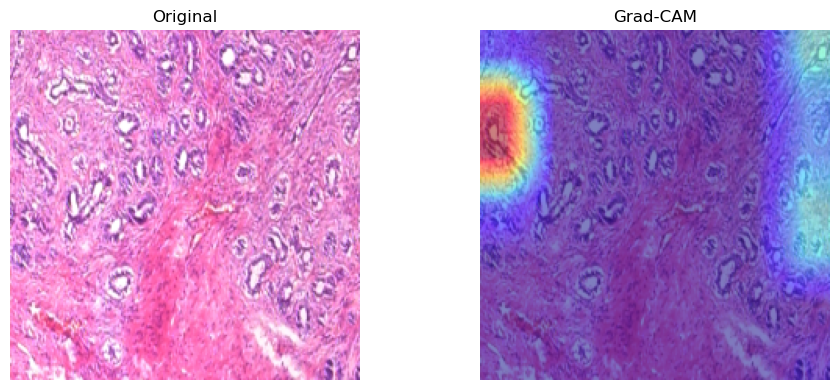

[INFO] Processing BreaKHis_40X_SOB_M_LC-14-16196-40-013.png


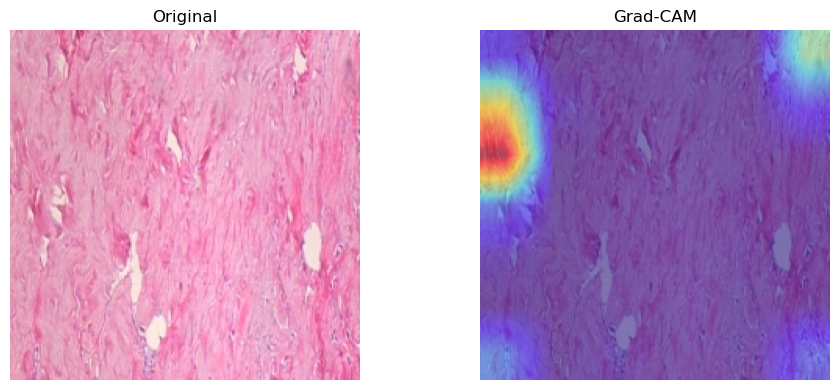


[INFO] Running Grad-CAM for ResNet18
[DEBUG] Available memory: 1830.91 MB
[ERROR] Failed for ResNet18: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

[INFO] Running Grad-CAM for VGG16
[DEBUG] Available memory: 1772.19 MB
[ERROR] Failed for VGG16: Error(s) in loading state_dict for VGG:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([2, 4096]) from checkpoint, the shape in current model is torch.Size([1, 4096]).
	size mismatch for classifier.6.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

[INFO] Running Grad-CAM for DenseNet
[DEBUG] Available memory: 979.81 MB
[ERROR] Failed for DenseNet: Error(s) in loading state_

In [5]:
import os
import torch
import numpy as np
import cv2
import gc
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
import psutil

# === Image Paths ===
benign_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\benign\BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png"
malignant_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\malignant\BreaKHis_40X_SOB_M_LC-14-16196-40-013.png"

image_paths = [(benign_img_path, 0), (malignant_img_path, 1)]

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === Grad-CAM Visualization ===
def generate_gradcam(model, cam_extractor, image_tensor, output_path):
    model.zero_grad()
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)

    class_score = output[:, 0].sum()  # Always using the only output neuron
    class_score.backward()

    cam = cam_extractor(0, output)[0].cpu().squeeze().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)
    cam_img = Image.fromarray(cam).resize((224, 224), resample=Image.BILINEAR)
    cam_img_np = np.array(cam_img)

    base_img = to_pil_image(image_tensor.cpu())
    base_np = np.array(base_img)

    heatmap = plt.cm.jet(cam_img_np / 255.0)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)
    overlay = np.uint8(0.5 * base_np + 0.5 * heatmap)

    Image.fromarray(overlay).save(output_path)

    # Show
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(base_np)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# === CBAM Module ===
import torch.nn as nn
from torchvision.models import resnet18, vgg16, densenet121
from efficientnet_pytorch import EfficientNet

class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)
        sa_input = torch.cat([max_out, mean_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

# === BreastNetPP ===
class BreastNetPP(nn.Module):
    def __init__(self):
        super(BreastNetPP, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.cbam = CBAM(1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)  # Binary classification

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.cbam(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)  # No sigmoid, leave raw logits

# === Other Models ===
def get_breastnetpp():
    return BreastNetPP()

def get_resnet18():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 1)
    return model

def get_vgg16():
    model = vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 1)
    return model

def get_densenet():
    model = densenet121(pretrained=False)
    model.classifier = nn.Linear(1024, 1)
    return model

# === Grad-CAM Execution ===
def run_gradcam_on_images(image_paths, model_paths, output_dir, device):
    for model_name, (model_fn, weight_path) in model_paths.items():
        print(f"\n[INFO] Running Grad-CAM for {model_name}")
        try:
            print(f"[DEBUG] Available memory: {psutil.virtual_memory().available / (1024 ** 2):.2f} MB")

            model = model_fn()
            checkpoint = torch.load(weight_path, map_location=device)
            model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
            model.to(device).eval()

            if model_name == "BreastNetPP":
                target_layer = model.cbam
            elif model_name == "ResNet18":
                target_layer = model.layer4[-1]
            elif model_name == "VGG16":
                target_layer = model.features[-1]
            elif model_name == "DenseNet":
                target_layer = model.features[-1]
            else:
                raise ValueError(f"Unknown model: {model_name}")

            cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

            for i, (img_path, label) in enumerate(image_paths):
                if not os.path.exists(img_path):
                    print(f"[ERROR] Image not found: {img_path}")
                    continue
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image)
                out_path = os.path.join(output_dir, f"{model_name}_{'benign' if label == 0 else 'malignant'}.png")
                print(f"[INFO] Processing {os.path.basename(img_path)}")
                generate_gradcam(model, cam_extractor, image_tensor, out_path)

        except Exception as e:
            print(f"[ERROR] Failed for {model_name}: {e}")
        finally:
            del model
            gc.collect()

# === Run ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_paths = {
    "BreastNetPP": (get_breastnetpp, r"D:\thisisimp\working-bc\saved_models\breastnetpp_epoch_5.pth"),
    "ResNet18": (get_resnet18, r"D:\thisisimp\working-bc\resnet18 models\resnet18_epoch5.pth"),
    "VGG16": (get_vgg16, r"D:\thisisimp\working-bc\vgg16 models\vgg16_best.pth"),
    "DenseNet": (get_densenet, r"D:\thisisimp\working-bc\Densenet model\densenet_best.pth"),
}

output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

run_gradcam_on_images(image_paths, model_paths, output_dir, device)


In [9]:
import os
import gc
import torch
import numpy as np
import cv2
import psutil
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18, vgg16, densenet121
from torchvision.transforms.functional import to_pil_image
from efficientnet_pytorch import EfficientNet
from torchcam.methods import SmoothGradCAMpp

# === Image Paths ===
benign_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\benign\BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png"
malignant_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\malignant\BreaKHis_40X_SOB_M_LC-14-16196-40-013.png"
image_paths = [(benign_img_path, 0), (malignant_img_path, 1)]

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === CBAM Module ===
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)
        sa_input = torch.cat([max_out, mean_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

# === BreastNetPP ===
class BreastNetPP(nn.Module):
    def __init__(self):
        super(BreastNetPP, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.cbam = CBAM(1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.cbam(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

# === Model Loader Functions ===
def get_breastnetpp():
    return BreastNetPP()

def get_resnet18():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 1)
    return model

def get_vgg16():
    model = vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 1)
    return model

def get_densenet():
    model = densenet121(pretrained=False)
    model.classifier = nn.Linear(1024, 1)
    return model

# === Grad-CAM Generator ===
def generate_gradcam(model, cam_extractor, image_tensor, output_path):
    model.zero_grad()
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    class_score = output[:, 0].sum()
    class_score.backward()

    cam = cam_extractor(0, output)[0].cpu().squeeze().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)
    cam_img = Image.fromarray(cam).resize((224, 224), resample=Image.BILINEAR)
    cam_img_np = np.array(cam_img)

    base_img = to_pil_image(image_tensor.cpu())
    base_np = np.array(base_img)

    heatmap = plt.cm.jet(cam_img_np / 255.0)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)
    overlay = np.uint8(0.5 * base_np + 0.5 * heatmap)

    Image.fromarray(overlay).save(output_path)

# === Grad-CAM Runner ===
def run_gradcam_on_images(image_paths, model_paths, output_dir, device):
    for model_name, (model_fn, weight_path) in model_paths.items():
        print(f"\n[INFO] Running Grad-CAM for {model_name}")
        try:
            print(f"[DEBUG] Available memory: {psutil.virtual_memory().available / (1024 ** 2):.2f} MB")
            model = model_fn()
            checkpoint = torch.load(weight_path, map_location=device)
            model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
            model.to(device).eval()

            if model_name == "BreastNetPP":
                target_layer = model.cbam
            elif model_name == "ResNet18":
                target_layer = model.layer4[-1]
            elif model_name == "VGG16":
                target_layer = model.features[-1]
            elif model_name == "DenseNet":
                target_layer = model.features[-1]
            else:
                raise ValueError(f"Unknown model: {model_name}")

            cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

            for img_path, label in image_paths:
                if not os.path.exists(img_path):
                    print(f"[ERROR] Image not found: {img_path}")
                    continue
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image)
                label_str = 'benign' if label == 0 else 'malignant'
                out_path = os.path.join(output_dir, f"{model_name}_{label_str}.png")
                print(f"[INFO] Saving: {out_path}")
                generate_gradcam(model, cam_extractor, image_tensor, out_path)

        except Exception as e:
            print(f"[ERROR] Failed for {model_name}: {e}")
        finally:
            del model
            gc.collect()

# === Setup & Run ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_paths = {
    "BreastNetPP": (get_breastnetpp, r"D:\thisisimp\working-bc\saved_models\breastnetpp_epoch_5.pth"),
    "ResNet18": (get_resnet18, r"D:\thisisimp\working-bc\resnet18 models\resnet18_epoch5.pth"),
    "VGG16": (get_vgg16, r"D:\thisisimp\working-bc\vgg16 models\vgg16_best.pth"),
    "DenseNet": (get_densenet, r"D:\thisisimp\working-bc\Densenet model\densenet_best.pth"),
}

output_dir = r"D:\thisisimp\working-bc\final gradcam"
os.makedirs(output_dir, exist_ok=True)

run_gradcam_on_images(image_paths, model_paths, output_dir, device)



[INFO] Running Grad-CAM for BreastNetPP
[DEBUG] Available memory: 445.26 MB
Loaded pretrained weights for efficientnet-b0
[INFO] Saving: D:\thisisimp\working-bc\final gradcam\BreastNetPP_benign.png
[INFO] Saving: D:\thisisimp\working-bc\final gradcam\BreastNetPP_malignant.png

[INFO] Running Grad-CAM for ResNet18
[DEBUG] Available memory: 1029.76 MB
[ERROR] Failed for ResNet18: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([2, 512]) from checkpoint, the shape in current model is torch.Size([1, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([2]) from checkpoint, the shape in current model is torch.Size([1]).

[INFO] Running Grad-CAM for VGG16
[DEBUG] Available memory: 933.63 MB
[ERROR] Failed for VGG16: Error(s) in loading state_dict for VGG:
	size mismatch for classifier.6.weight: copying a param with shape torch.Size([2, 4096]) from checkpoint, the shape in current model is torch.Size([1, 4096]


[INFO] Running Grad-CAM for BreastNetPP
[DEBUG] Available memory: 1041.86 MB
Loaded pretrained weights for efficientnet-b0
[ERROR] Failed for BreastNetPP: Error(s) in loading state_dict for BreastNetPP:
	Missing key(s) in state_dict: "attn.channel_attention.1.weight", "attn.channel_attention.3.weight", "attn.spatial_attention.0.weight". 
	Unexpected key(s) in state_dict: "cbam.channel_attention.1.weight", "cbam.channel_attention.3.weight", "cbam.spatial_attention.0.weight". 
	size mismatch for fc2.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([2, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

[INFO] Running Grad-CAM for ResNet18
[DEBUG] Available memory: 1027.28 MB
[INFO] Processing BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png


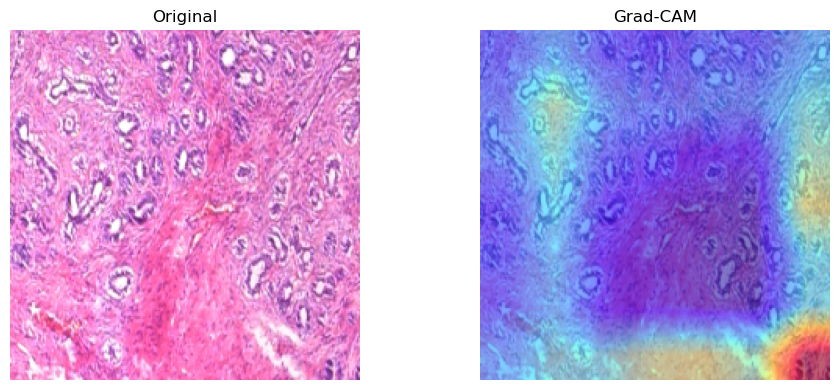

[INFO] Processing BreaKHis_40X_SOB_M_LC-14-16196-40-013.png


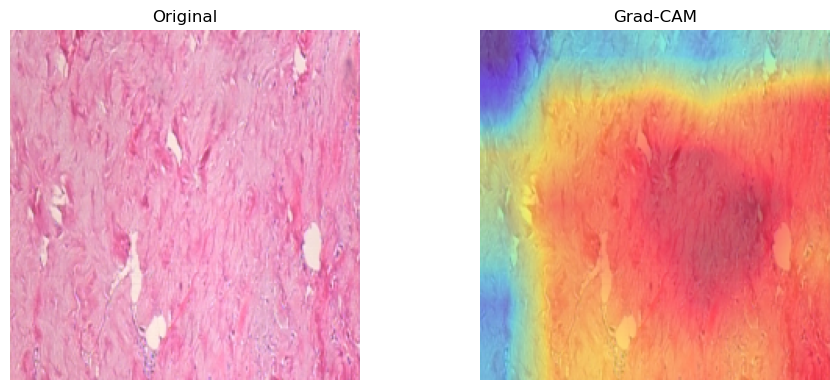


[INFO] Running Grad-CAM for VGG16
[DEBUG] Available memory: 823.08 MB
[INFO] Processing BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png


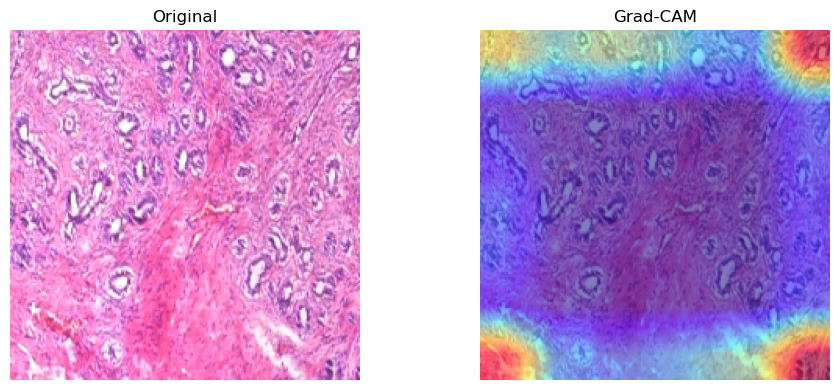

[INFO] Processing BreaKHis_40X_SOB_M_LC-14-16196-40-013.png


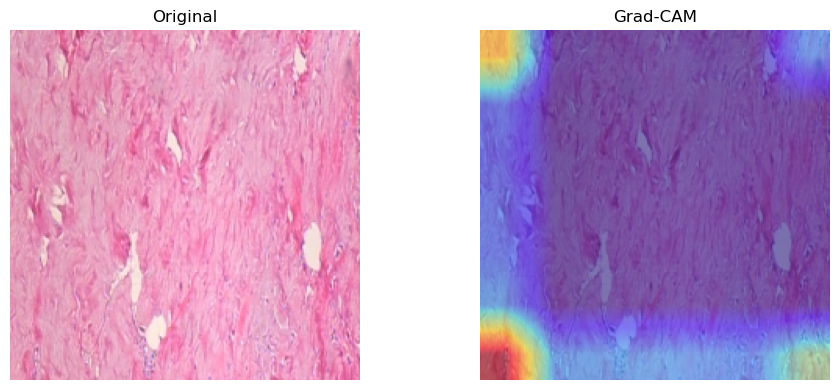


[INFO] Running Grad-CAM for DenseNet
[DEBUG] Available memory: 567.15 MB
[INFO] Processing BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png


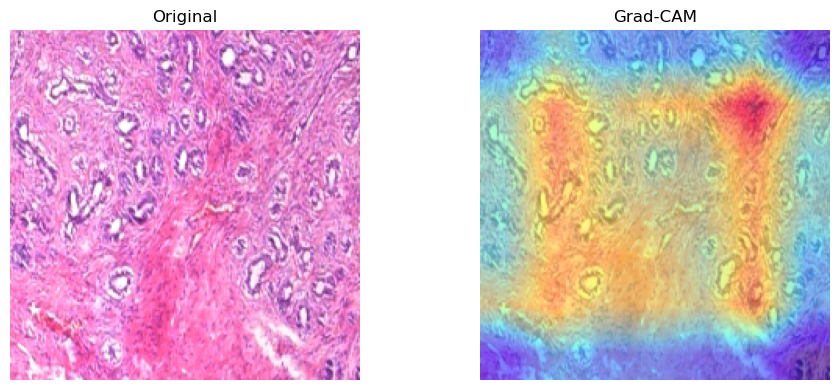

[INFO] Processing BreaKHis_40X_SOB_M_LC-14-16196-40-013.png


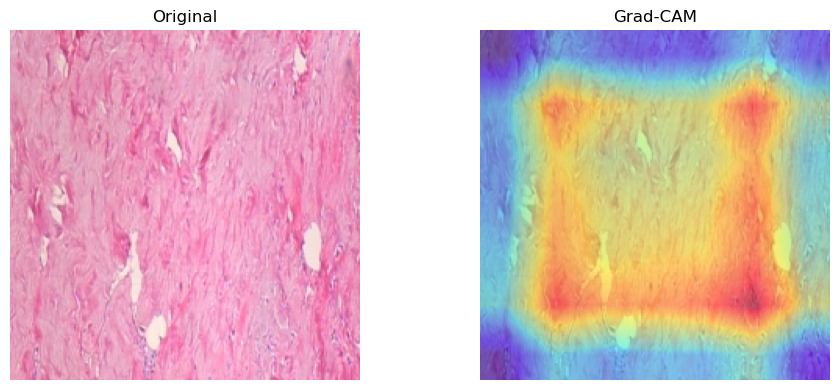

In [11]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import gc
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
from PIL import Image
from torchcam.methods import SmoothGradCAMpp
from torchvision.models import resnet18, vgg16, densenet121
from efficientnet_pytorch import EfficientNet
import psutil

# === Image Paths ===
benign_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\benign\BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png"
malignant_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\malignant\BreaKHis_40X_SOB_M_LC-14-16196-40-013.png"

image_paths = [(benign_img_path, 0), (malignant_img_path, 1)]

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === CBAM Module ===
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)
        sa_input = torch.cat([max_out, mean_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

# === BreastNetPP ===
class BreastNetPP(nn.Module):
    def __init__(self):
        super(BreastNetPP, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.attn = CBAM(1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.attn(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

# === Model Loaders ===
def get_breastnetpp():
    return BreastNetPP()

def get_resnet18():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 2)
    return model

def get_vgg16():
    model = vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 2)
    return model

def get_densenet():
    model = densenet121(pretrained=False)
    model.classifier = nn.Linear(1024, 2)
    return model

# === Grad-CAM Generator ===
def generate_gradcam(model, cam_extractor, image_tensor, class_idx, output_path):
    model.zero_grad()
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    class_score = output[:, class_idx].sum()
    class_score.backward()

    cam = cam_extractor(class_idx, output)[0].cpu().squeeze().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)
    cam_img = Image.fromarray(cam).resize((224, 224), resample=Image.BILINEAR)
    cam_img_np = np.array(cam_img)

    base_img = to_pil_image(image_tensor.cpu())
    base_np = np.array(base_img)

    heatmap = plt.cm.jet(cam_img_np / 255.0)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)
    overlay = np.uint8(0.5 * base_np + 0.5 * heatmap)

    # === Save Output ===
    Image.fromarray(overlay).save(output_path)

    # Optional display
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(base_np)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# === Grad-CAM Runner ===
def run_gradcam_on_images(image_paths, model_paths, output_dir, device):
    for model_name, (model_fn, weight_path) in model_paths.items():
        print(f"\n[INFO] Running Grad-CAM for {model_name}")
        print(f"[DEBUG] Available memory: {psutil.virtual_memory().available / 1024**2:.2f} MB")
        model = cam_extractor = None
        try:
            model = model_fn()
            checkpoint = torch.load(weight_path, map_location=device)
            model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
            model.to(device).eval()

            # Select target layer
            if model_name == "BreastNetPP":
                target_layer = model.attn
            elif model_name == "ResNet18":
                target_layer = model.layer4[-1]
            elif model_name == "VGG16":
                target_layer = model.features[-1]
            elif model_name == "DenseNet":
                target_layer = model.features[-1]
            else:
                raise ValueError(f"Unknown model: {model_name}")

            cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

            for img_path, label in image_paths:
                if not os.path.exists(img_path):
                    print(f"[ERROR] Image not found: {img_path}")
                    continue
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image)
                class_name = "benign" if label == 0 else "malignant"
                out_path = os.path.join(output_dir, f"{model_name}_{class_name}.png")
                print(f"[INFO] Processing {os.path.basename(img_path)}")
                generate_gradcam(model, cam_extractor, image_tensor, label, out_path)

        except Exception as e:
            print(f"[ERROR] Failed for {model_name}: {e}")
        finally:
            if model: del model
            if cam_extractor: del cam_extractor
            gc.collect()

# === Main Execution ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = "gradcam_outputs"
os.makedirs(output_dir, exist_ok=True)

model_paths = {
    "BreastNetPP": (get_breastnetpp, r"D:\thisisimp\working-bc\saved_models\breastnetpp_epoch_5.pth"),
    "ResNet18": (get_resnet18, r"D:\thisisimp\working-bc\resnet18 models\resnet18_epoch5.pth"),
    "VGG16": (get_vgg16, r"D:\thisisimp\working-bc\vgg16 models\vgg16_best.pth"),
    "DenseNet": (get_densenet, r"D:\thisisimp\working-bc\Densenet model\densenet_best.pth"),
}

run_gradcam_on_images(image_paths, model_paths, output_dir, device)


In [12]:
import os
import gc
import torch
import numpy as np
import cv2
import psutil
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet18, vgg16, densenet121
from torchvision.transforms.functional import to_pil_image
from efficientnet_pytorch import EfficientNet
from torchcam.methods import SmoothGradCAMpp

# === Image Paths ===
benign_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\benign\BreaKHis_40X_SOB_B_TA-14-16184CD-40-007.png"
malignant_img_path = r"D:\thisisimp\working-bc\Preprocessed\test\malignant\BreaKHis_40X_SOB_M_LC-14-16196-40-013.png"
image_paths = [(benign_img_path, 0), (malignant_img_path, 1)]

# === Transform ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# === CBAM Attention ===
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x)
        x = x * ca
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        mean_out = torch.mean(x, dim=1, keepdim=True)
        sa_input = torch.cat([max_out, mean_out], dim=1)
        sa = self.spatial_attention(sa_input)
        x = x * sa
        return x

# === BreastNetPP ===
class BreastNetPP(nn.Module):
    def __init__(self):
        super(BreastNetPP, self).__init__()
        self.backbone = EfficientNet.from_pretrained('efficientnet-b0')
        self.attn = CBAM(1280)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1280, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.backbone.extract_features(x)
        x = self.attn(x)
        x = self.pool(x).view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

# === Model Loaders ===
def get_breastnetpp():
    return BreastNetPP()

def get_resnet18():
    model = resnet18(pretrained=False)
    model.fc = nn.Linear(512, 2)
    return model

def get_vgg16():
    model = vgg16(pretrained=False)
    model.classifier[6] = nn.Linear(4096, 2)
    return model

def get_densenet():
    model = densenet121(pretrained=False)
    model.classifier = nn.Linear(1024, 2)
    return model

# === Grad-CAM Generator ===
def generate_gradcam(model, cam_extractor, image_tensor, class_idx, model_name, class_name, output_dir):
    model.zero_grad()
    input_tensor = image_tensor.unsqueeze(0).to(device)
    output = model(input_tensor)
    class_score = output[:, class_idx].sum()
    class_score.backward()

    # === Grad-CAM extraction ===
    cam = cam_extractor(class_idx, output)[0].cpu().squeeze().numpy()
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)
    cam_img = Image.fromarray(cam).resize((224, 224), resample=Image.BILINEAR)
    cam_img_np = np.array(cam_img)

    base_img = to_pil_image(image_tensor.cpu())
    base_np = np.array(base_img)

    heatmap = plt.cm.jet(cam_img_np / 255.0)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)
    overlay = np.uint8(0.5 * base_np + 0.5 * heatmap)

    # === Save All Outputs ===
    overlay_path = os.path.join(output_dir, f"{model_name}_{class_name}_overlay.png")
    heatmap_path = os.path.join(output_dir, f"{model_name}_{class_name}_heatmap.png")
    original_path = os.path.join(output_dir, f"{model_name}_{class_name}_original.png")

    Image.fromarray(overlay).save(overlay_path)
    Image.fromarray(cam_img_np).save(heatmap_path)
    base_img.save(original_path)

    print(f"[INFO] Saved: {overlay_path}, {heatmap_path}, {original_path}")

# === Grad-CAM Runner ===
def run_gradcam_on_images(image_paths, model_paths, output_dir, device):
    for model_name, (model_fn, weight_path) in model_paths.items():
        print(f"\n[INFO] Running Grad-CAM for {model_name}")
        print(f"[DEBUG] Available memory: {psutil.virtual_memory().available / 1024**2:.2f} MB")
        model = cam_extractor = None
        try:
            model = model_fn()
            checkpoint = torch.load(weight_path, map_location=device)
            model.load_state_dict(checkpoint.get("model_state_dict", checkpoint))
            model.to(device).eval()

            if model_name == "BreastNetPP":
                target_layer = model.attn
            elif model_name == "ResNet18":
                target_layer = model.layer4[-1]
            elif model_name == "VGG16":
                target_layer = model.features[-1]
            elif model_name == "DenseNet":
                target_layer = model.features[-1]
            else:
                raise ValueError(f"Unknown model: {model_name}")

            cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)

            for img_path, label in image_paths:
                if not os.path.exists(img_path):
                    print(f"[ERROR] Image not found: {img_path}")
                    continue
                image = Image.open(img_path).convert("RGB")
                image_tensor = transform(image)
                class_name = "benign" if label == 0 else "malignant"
                generate_gradcam(model, cam_extractor, image_tensor, label, model_name, class_name, output_dir)

        except Exception as e:
            print(f"[ERROR] Failed for {model_name}: {e}")
        finally:
            if model:
                del model
            if cam_extractor:
                del cam_extractor
            gc.collect()

# === Main ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
output_dir = r"D:\thisisimp\working-bc\final gradcam outputs"
os.makedirs(output_dir, exist_ok=True)

model_paths = {
    "BreastNetPP": (get_breastnetpp, r"D:\thisisimp\working-bc\saved_models\breastnetpp_epoch_5.pth"),
    "ResNet18": (get_resnet18, r"D:\thisisimp\working-bc\resnet18 models\resnet18_epoch5.pth"),
    "VGG16": (get_vgg16, r"D:\thisisimp\working-bc\vgg16 models\vgg16_best.pth"),
    "DenseNet": (get_densenet, r"D:\thisisimp\working-bc\Densenet model\densenet_best.pth"),
}

run_gradcam_on_images(image_paths, model_paths, output_dir, device)



[INFO] Running Grad-CAM for BreastNetPP
[DEBUG] Available memory: 980.66 MB
Loaded pretrained weights for efficientnet-b0
[ERROR] Failed for BreastNetPP: Error(s) in loading state_dict for BreastNetPP:
	Missing key(s) in state_dict: "attn.channel_attention.1.weight", "attn.channel_attention.3.weight", "attn.spatial_attention.0.weight". 
	Unexpected key(s) in state_dict: "cbam.channel_attention.1.weight", "cbam.channel_attention.3.weight", "cbam.spatial_attention.0.weight". 
	size mismatch for fc2.weight: copying a param with shape torch.Size([1, 128]) from checkpoint, the shape in current model is torch.Size([2, 128]).
	size mismatch for fc2.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([2]).

[INFO] Running Grad-CAM for ResNet18
[DEBUG] Available memory: 848.71 MB
[INFO] Saved: D:\thisisimp\working-bc\final gradcam outputs\ResNet18_benign_overlay.png, D:\thisisimp\working-bc\final gradcam outputs\ResNet18_benign_heatmap.png